In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns
pd.set_option('display.max_rows', 8)
%matplotlib inline
!date

Wed Jan 31 16:36:18 PST 2018


# Modeling Boids in Vivarium

Bird flocking behavoir is a good place to start microsimulation/individual-based modeling/agent-based modeling.  It is pretty and pretty simple.

This notebook updates [my previous attempt](/notebooks/2017/2017_06_04b_ceam_boids.ipynb), which relied on notes from http://www.kfish.org/boids/pseudocode.html)

In [2]:
import vivarium, vivarium.test_util as vtu

np.random.seed(12345)  # set random seed for reproducibility

n_simulants = 300
n_days = 1000
t_timestep = 1 # days
t_start = pd.Timestamp('1990-01-01')

# Model Zero: A "base population" of birds

In [3]:
from vivarium.framework.event import listens_for
from vivarium.framework.population import uses_columns

class Boids:
    def setup(self, builder):
        self.population_view = builder.population_view(['x', 'y', 'vx', 'vy'])
        
    @listens_for('initialize_simulants')
    def do_initalize_simulants(self, event):
        """Start new simulants with a random location and random direction
        """
        pop = pd.DataFrame(index=event.index)

        pop['x'] = np.random.uniform(size=len(pop))
        pop['y'] = np.random.uniform(size=len(pop))

        pop['vx'] = .1*np.random.uniform(size=len(pop))
        pop['vy'] = .1*np.random.uniform(size=len(pop))

        # update the population in the model
        self.population_view.update(pop)


In [4]:
sim = vtu.setup_simulation([Boids()], population_size=n_simulants, start=t_start)
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=pd.Timedelta(days=n_days))

VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

1000

Let's have a look at our flock:

In [5]:
df = sim.population.population  # a copy of the population table

In [6]:
df

,vy,y,vx,x
0,0.019455,0.296088,0.046727,0.929616
1,0.052026,0.798515,0.093282,0.316376
2,0.046490,0.294778,0.090976,0.183919
3,0.078951,0.697122,0.012993,0.204560
...,...,...,...,...
296,0.000970,0.797973,0.095667,0.999414
297,0.081632,0.244245,0.015601,0.507327
298,0.081894,0.803538,0.075773,0.493067
299,0.030449,0.298175,0.004134,0.186875


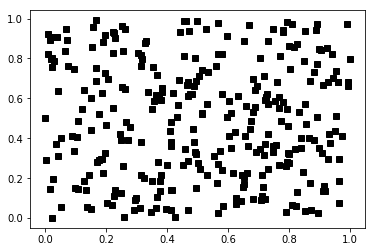

In [7]:
plt.plot(df.x, df.y, 'ks')

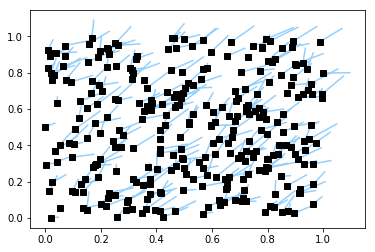

In [8]:
def my_plot(df):
    # is there an easy way to plot the velocities?
    xx = []
    yy = []
    for i in df.index:
        xx += [df.x[i], df.x[i]+df.vx[i], np.nan]
        yy += [df.y[i], df.y[i]+df.vy[i], np.nan]

    plt.plot(xx, yy, sns.xkcd_rgb['light blue'])
    plt.plot(df.x, df.y, 'ks')
my_plot(df)

Looks nice, but these birds don't move. On each timestep of the simulation, let's update the position based on the velocity.

In [9]:
from vivarium.framework.event import listens_for
from vivarium.framework.population import uses_columns

class Boids:
    def setup(self, builder):
        self.population_view = builder.population_view(['x', 'y', 'vx', 'vy'])
        
    @listens_for('initialize_simulants')
    def do_initalize_simulants(self, event):
        """Start new simulants with a random location and random direction
        """
        pop = pd.DataFrame(index=event.index)

        pop['x'] = np.random.uniform(size=len(pop))
        pop['y'] = np.random.uniform(size=len(pop))

        pop['vx'] = .1*np.random.uniform(size=len(pop))
        pop['vy'] = .1*np.random.uniform(size=len(pop))

        # update the population in the model
        self.population_view.update(pop)

    @listens_for('time_step')
    def do_time_step(self, event):
        pop = self.population_view.get(event.index)
        pop.x += pop.vx
        pop.y += pop.vy
        
        # update the population in the model
        # (NOTE: I left this out the first time, interesting teaching moment)
        self.population_view.update(pop)


In [10]:
sim = vtu.setup_simulation([Boids()], population_size=n_simulants, start=t_start)
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=pd.Timedelta(days=n_days))

VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

1000

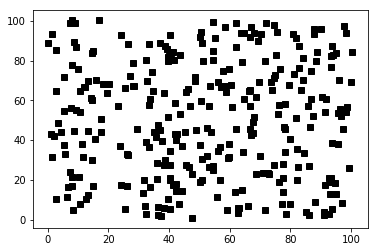

In [11]:
# did they move?
my_plot(sim.population.population)

# Model One: the three rules of Boids

The beautiful flocking behavior of the Boids model emerges from the interaction of three simple(-ish) rules. We will develop the rules as separate components to demonstrate the modular design of `vivarium`.  In practice, the grouping of functionality into modular components is a bit of an art, and it could be more elegant to put all three rules in the same component.  You decide.

In [12]:
class SeekCenter:
    def velocity_towards_center(self, t):
        """Rule 1: Boids try to fly towards the 
        center of mass of neighbouring boids.
        """
        # center of mass
        cx, cy = t.x.mean(), t.y.mean()

        return .1*(cx - t.x), .1*(cy - t.y) 
    
    @listens_for('time_step__prepare')
    @uses_columns(['x', 'y', 'vx', 'vy'])
    def on_time_step(self, event):
        t = event.population
        v1x, v1y = self.velocity_towards_center(t)

        t.vx += v1x
        t.vy += v1y

        event.population_view.update(t)


sim = vtu.setup_simulation([Boids(), SeekCenter()], population_size=n_simulants, start=t_start)
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=pd.Timedelta(days=n_days))

VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

1000

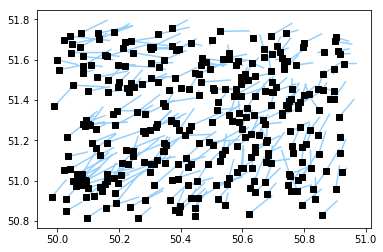

In [13]:
# where do my birds end up now?
my_plot(sim.population.population)

Let's layer another two rules on that.

In [14]:
def d(t, i, j):
    """convenience function to calculate the squared distance between t.x and t.y for index i"""
    dx = t.x[i] - t.x[j]
    dy = t.y[i] - t.y[j]
    return dx*dx + dy*dy


class AvoidPersonalSpace:
    def rule2(self, t):
        """Rule 2: Boids try to keep a small distance away from other objects (including other boids).
        """
        #     dvx = np.zeros_like(t.vx)
        #     dvy = np.zeros_like(t.vy)

        #     for i in range(len(t)):
        #         for j in range(i+1, len(t)):
        #             if d(t, i, j) < .1:
        #                 dvx[i] -= (t.x[j] - t.x[i])
        #                 dvy[i] -= (t.y[j] - t.y[i])

        # the above seems slow, let's just stay away from center of mass
        cx, cy = t.x.mean(), t.y.mean()
        dx = (t.x - cx)
        dy = (t.y - cy)

        close = dx*dx + dy*dy < .01
        dvx = np.where(close, t.x - cx, 0)
        dvy = np.where(close, t.y - cy, 0)

        return dvx, dvy

    
    @listens_for('time_step__prepare')
    @uses_columns(['x', 'y', 'vx', 'vy'])
    def on_time_step(self, event):
        t = event.population
        v2x, v2y = self.rule2(t)

        t.vx += v2x
        t.vy += v2y

        event.population_view.update(t)

class MatchVelocity:
    def rule3(self, t):
        """Rule 3: Boids try to match velocity with near boids.
        """
        # mean velocity
        mvx, mvy = t.vx.mean(), t.vy.mean()

        return .1*(mvx - t.vx), .1*(mvy - t.vy) 
    
    @listens_for('time_step__prepare')
    @uses_columns(['x', 'y', 'vx', 'vy'])
    def on_time_step(self, event):
        t = event.population
        v3x, v3y = self.rule3(t)

        t.vx += v3x
        t.vy += v3y

        event.population_view.update(t)

sim = vtu.setup_simulation([Boids(), SeekCenter(), AvoidPersonalSpace(), MatchVelocity()],
                           population_size=n_simulants, start=t_start)
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=pd.Timedelta(days=n_days))

VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

1000

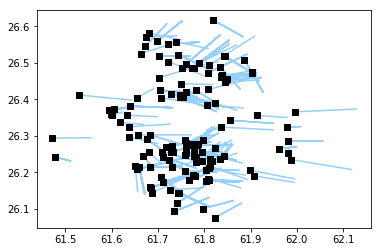

In [15]:
my_plot(sim.population.population)

## Diversion: Let's see that
(or perhaps this is not a diversion, but an opportunity to further demonstrate modular design principles.)

I would like to see an animation (or at least a flip book) of my Boids moving around during this simulation.  Here is a way to get one:

VBox(children=(HTML(value=''), IntProgress(value=0, max=3)))

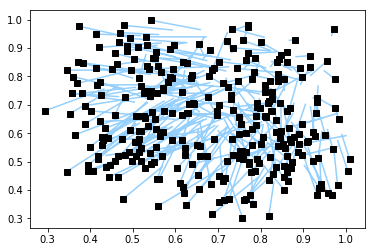

In [16]:
from matplotlib import animation

class MovieWriter:
    def __init__(self, fname):
        self.moviewriter = animation.ImageMagickWriter(fps=10)
        self.fname = fname
            
    def __enter__(self):
        fig = plt.figure()
        self.moviewriter.setup(fig, self.fname, dpi=100)
        return self
    
    def setup(self, builder):
        self.population_view = builder.population_view(['x', 'y', 'vx', 'vy'])
        
    @listens_for('collect_metrics')
    def on_collect_metrics(self, event):
        pop = self.population_view.get(event.index)
        
        plt.clf()
        my_plot(pop)

        self.moviewriter.grab_frame()

    def __exit__(self, exception_type, exception_value, traceback):
        self.moviewriter.finish()

with MovieWriter('t.gif') as mw:
    sim = vtu.setup_simulation([Boids(), SeekCenter(), AvoidPersonalSpace(), MatchVelocity(), mw],
                               population_size=n_simulants, start=t_start)
    vtu.pump_simulation(sim, time_step_days=t_timestep, duration=3)

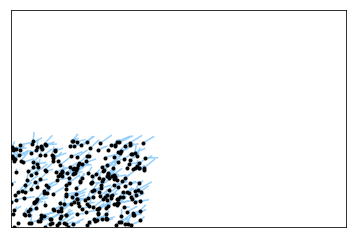

In [17]:
# making things look nice is always fiddley

def my_plot(df):
    x = np.mod(df.x, 2.5)
    y = np.mod(df.y, 2.5)
    
    # is there an easy way to plot the velocities?
    xx = []
    yy = []
    for i in df.index:
        xx += [x[i], x[i]+df.vx[i], np.nan]
        yy += [y[i], y[i]+df.vy[i], np.nan]

    plt.plot(xx, yy, sns.xkcd_rgb['light blue'])
    plt.plot(x, y, 'k.')
    plt.axis(xmin=0, ymin=0, xmax=2.5, ymax=2.5)
    plt.xticks([])
    plt.yticks([])
my_plot(df)

VBox(children=(HTML(value=''), IntProgress(value=0, max=300)))

CPU times: user 46.7 s, sys: 37.7 s, total: 1min 24s
Wall time: 1min


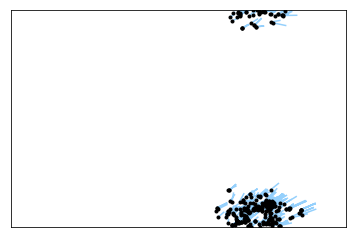

In [18]:
%%time

with MovieWriter('t.gif') as mw:
    sim = vtu.setup_simulation([Boids(), SeekCenter(), AvoidPersonalSpace(), MatchVelocity(), mw],
                               population_size=n_simulants, start=t_start)
    vtu.pump_simulation(sim, time_step_days=t_timestep, duration=300)

# Model 2: make one bird special

In [19]:
class SpecialBird:
    @listens_for('time_step')
    @uses_columns(['x', 'y', 'vx', 'vy'])
    def on_time_step(self, event):
        t = event.time
        
        df = event.population
        df.loc[:30, 'x'] = 1.5+np.sin(.005*(t-t_start)/pd.Timedelta(days=1))
        df.loc[:30, 'y'] = 1.5+np.cos(.005*(t-t_start)/pd.Timedelta(days=1))
        df.loc[:30, 'vx'] = 0
        df.loc[:30, 'vy'] = 0

        event.population_view.update(df)

sim = vtu.setup_simulation([Boids(), SeekCenter(), AvoidPersonalSpace(), MatchVelocity(), SpecialBird()],
                           population_size=n_simulants, start=t_start)
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=5)

VBox(children=(HTML(value=''), IntProgress(value=0, max=5)))

5

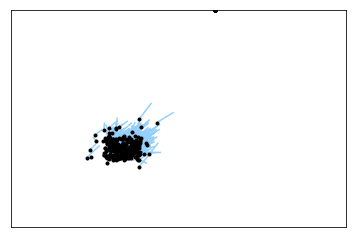

In [20]:
my_plot(sim.population.population)

VBox(children=(HTML(value=''), IntProgress(value=0, max=300)))

CPU times: user 45.5 s, sys: 38.3 s, total: 1min 23s
Wall time: 1min 2s


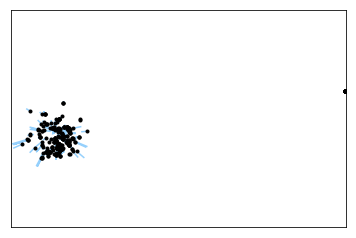

In [21]:
%%time

with MovieWriter('t.gif') as mw:
    sim = vtu.setup_simulation([Boids(), SeekCenter(), AvoidPersonalSpace(), MatchVelocity(), SpecialBird(), mw],
                               population_size=n_simulants, start=t_start)
    vtu.pump_simulation(sim, time_step_days=t_timestep, duration=300)

In [22]:
# value pipeline!